In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]")\
.config("spark.jars.packages", "graphframes:graphframes:0.8.4-spark3.5-s_2.12")\
.config("spark.executor.memory", "8G")\
.config("spark.driver.memory", "2g")\
.getOrCreate()

In [26]:
! pip install graphframes

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from graphframes import GraphFrame
from pyspark.sql.functions import col, when, unix_timestamp, hour

In [28]:

# Initialiser Spark
spark = SparkSession.builder.appName("GTFSGraph").getOrCreate()

# Charger les fichiers CSV
trip_updates = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/BIg_Data/trip_updates.csv", header=True, inferSchema=True)
vehicle_positions = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/BIg_Data/VP.csv", header=True, inferSchema=True)


In [29]:
trip_updates.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- route_id: string (nullable = true)
 |-- start_date: integer (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- direction_id: integer (nullable = true)
 |-- vehicle_id: string (nullable = true)
 |-- stop_id: integer (nullable = true)
 |-- arrival_time: timestamp (nullable = true)
 |-- departure_time: timestamp (nullable = true)



In [30]:
vehicle_positions.printSchema()

root
 |-- vehicle_type: string (nullable = true)
 |-- nextStop: integer (nullable = true)
 |-- desi: string (nullable = true)
 |-- dir: integer (nullable = true)
 |-- oper: integer (nullable = true)
 |-- veh: integer (nullable = true)
 |-- tst: timestamp (nullable = true)
 |-- tsi: integer (nullable = true)
 |-- spd: double (nullable = true)
 |-- hdg: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- acc: double (nullable = true)
 |-- dl: integer (nullable = true)
 |-- odo: integer (nullable = true)
 |-- drst: integer (nullable = true)
 |-- oday: date (nullable = true)
 |-- jrn: integer (nullable = true)
 |-- line: integer (nullable = true)
 |-- start: timestamp (nullable = true)
 |-- loc: string (nullable = true)
 |-- stop: integer (nullable = true)
 |-- route: string (nullable = true)
 |-- occu: integer (nullable = true)



# Calcul des Retards des Véhicules

## Retard basé sur trip_updates

In [31]:
trip_updates = trip_updates.withColumn(
    "delay", (unix_timestamp("arrival_time") - unix_timestamp("start_time"))
)

trip_updates = trip_updates.withColumn(
    "delay_category",
    when(col("delay") < -60, "Avance")
    .when(col("delay") > 300, "Retard")
    .otherwise("À l'heure")
)

trip_updates.select("trip_id", "route_id", "stop_id", "delay", "delay_category").show()


+--------------------+--------+-------+--------+--------------+
|             trip_id|route_id|stop_id|   delay|delay_category|
+--------------------+--------+-------+--------+--------------+
|2124_20250116_11:...|    2124|2411217|-1303088|        Avance|
|2124_20250116_11:...|    2124|2411259|-1303062|        Avance|
|2124_20250116_11:...|    2124|2443228|-1302951|        Avance|
|2124_20250116_11:...|    2124|2411225|-1302878|        Avance|
|2124_20250116_11:...|    2124|2432231|-1302747|        Avance|
|2124_20250116_11:...|    2124|2434229|-1302727|        Avance|
|2124_20250116_11:...|    2124|2434227|-1302666|        Avance|
|2124_20250116_11:...|    2124|2432226|-1302630|        Avance|
|2124_20250116_11:...|    2124|2432224|-1302582|        Avance|
|2124_20250116_11:...|    2124|2432222|-1302514|        Avance|
|2124_20250116_11:...|    2124|2432219|-1302452|        Avance|
|2124_20250116_11:...|    2124|2432217|-1302384|        Avance|
|2124_20250116_11:...|    2124|2321222|-

##  Retard basé sur vehicle_positions

In [32]:
vehicle_positions = vehicle_positions.withColumn(
    "delay_category",
    when(col("dl") < -60, "Avance")
    .when(col("dl") > 300, "Retard")
    .otherwise("À l'heure")
)

vehicle_positions.select("veh", "route", "dl", "delay_category").show()


+----+-----+------+--------------+
| veh|route|    dl|delay_category|
+----+-----+------+--------------+
| 139| 31M1|  NULL|     À l'heure|
| 971| 1053|     0|     À l'heure|
| 693| 4522|   -17|     À l'heure|
|1437| 1057|   -60|     À l'heure|
|1020|3002A|   -53|     À l'heure|
|2208| 4570|  -231|        Avance|
|  71| 1002|    74|     À l'heure|
| 100| 6919|-22023|        Avance|
| 211| 9641|   -47|     À l'heure|
| 432| 1006|   -60|     À l'heure|
| 821| 1813|  -119|        Avance|
|  34| 1054|    55|     À l'heure|
|1602| 4721|   -60|     À l'heure|
| 455| 1008|     0|     À l'heure|
|1022|3001I|     0|     À l'heure|
|1022|3001I|     0|     À l'heure|
|1276| 1040|  -539|        Avance|
|1243| 1020|  -180|        Avance|
| 444| 1055|    59|     À l'heure|
|  62| 1073|  -110|        Avance|
+----+-----+------+--------------+
only showing top 20 rows



In [33]:
trip_updates.groupBy("route_id").agg({"delay": "avg"}).orderBy("avg(delay)", ascending=True).show()


+--------+-------------------+
|route_id|         avg(delay)|
+--------+-------------------+
|  2349BK|         -1303358.0|
|    4588|         -1303357.0|
|    9665|         -1303330.0|
|   2166K|         -1303281.0|
|    4434|-1303153.6666666667|
|    1096|-1303109.3333333333|
|    9976|-1302970.1818181819|
|    1098|-1302960.4545454546|
|   1022B|         -1302952.5|
|    1089|-1302938.8181818181|
|    1813|      -1302914.1875|
|    1033|-1302908.7333333334|
|    1090|-1302887.4166666667|
|    4734|-1302882.6818181819|
|   4522B|-1302867.7307692308|
|    2166|        -1302837.25|
|    1814|        -1302828.75|
|    1816|-1302826.7272727273|
|    2203|-1302814.1666666667|
|    9978|         -1302810.6|
+--------+-------------------+
only showing top 20 rows



In [34]:
trip_updates.groupBy("stop_id").agg({"delay": "avg"}).orderBy("avg(delay)", ascending=False).show(5)


+-------+----------+
|stop_id|avg(delay)|
+-------+----------+
|1492123|-1298637.0|
|1452103|-1298647.0|
|1492121|-1298659.0|
|1455111|-1298953.0|
|1140125|-1299016.8|
+-------+----------+
only showing top 5 rows



In [35]:
trip_updates.select("trip_id", "stop_id", "start_time", "arrival_time").show(10, False)


+------------------------+-------+-------------------+-------------------+
|trip_id                 |stop_id|start_time         |arrival_time       |
+------------------------+-------+-------------------+-------------------+
|2124_20250116_11:21:00_1|2411217|2025-01-31 11:21:00|2025-01-16 09:22:52|
|2124_20250116_11:21:00_1|2411259|2025-01-31 11:21:00|2025-01-16 09:23:18|
|2124_20250116_11:21:00_1|2443228|2025-01-31 11:21:00|2025-01-16 09:25:09|
|2124_20250116_11:21:00_1|2411225|2025-01-31 11:21:00|2025-01-16 09:26:22|
|2124_20250116_11:21:00_1|2432231|2025-01-31 11:21:00|2025-01-16 09:28:33|
|2124_20250116_11:21:00_1|2434229|2025-01-31 11:21:00|2025-01-16 09:28:53|
|2124_20250116_11:21:00_1|2434227|2025-01-31 11:21:00|2025-01-16 09:29:54|
|2124_20250116_11:21:00_1|2432226|2025-01-31 11:21:00|2025-01-16 09:30:30|
|2124_20250116_11:21:00_1|2432224|2025-01-31 11:21:00|2025-01-16 09:31:18|
|2124_20250116_11:21:00_1|2432222|2025-01-31 11:21:00|2025-01-16 09:32:26|
+------------------------

In [36]:
trip_updates = trip_updates.withColumn("hour", hour(col("arrival_time")))

trip_updates.groupBy("hour").agg({"delay": "avg"}).orderBy("hour").show()


+----+-------------------+
|hour|         avg(delay)|
+----+-------------------+
|   8| -1302943.637735849|
|   9|-1302084.2437155603|
|  10|-1301032.9117833185|
|  11|         -1300020.0|
+----+-------------------+



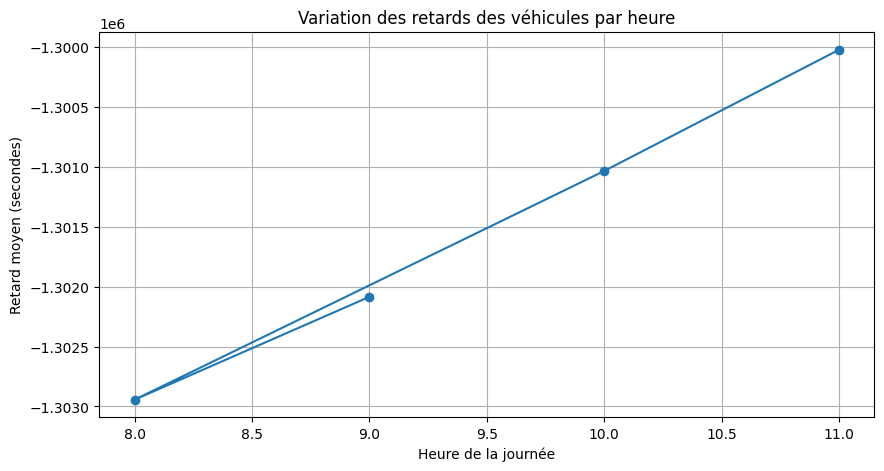

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

df = trip_updates.groupBy("hour").agg({"delay": "avg"}).toPandas()

plt.figure(figsize=(10,5))
plt.plot(df["hour"], df["avg(delay)"], marker="o")
plt.xlabel("Heure de la journée")
plt.ylabel("Retard moyen (secondes)")
plt.title("Variation des retards des véhicules par heure")
plt.grid()
plt.show()




 Choix des Sommets et Arêtes
Sommets (nœuds) :

stop_id (arrêts de bus)

vehicle_id (véhicules)

trip_id (trajets)

Arêtes (relations) :

(stop_id) --[utilisé par]--> (trip_id)

(trip_id) --[assigné à]--> (vehicle_id)

(stop_id) --[suivi de]--> (stop_id suivant)

In [38]:
! pip  install Pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.7 MB/s eta 0:00:00


In [40]:
import networkx as nx
from pyvis.network import Network
import pandas as pd

# Convertir Spark DataFrame en Pandas
trip_updates_df = trip_updates.select("trip_id", "route_id", "stop_id", "vehicle_id").toPandas()
vehicle_positions_df = vehicle_positions.select("veh", "route", "stop", "dl").toPandas()

# Créer un graphe dirigé
G = nx.DiGraph()

# Ajouter les arrêts comme nœuds (Convertir en str)
for stop in trip_updates_df["stop_id"].dropna().unique():
    G.add_node(str(stop), label=f"Stop {stop}", color="blue", size=10)

# Ajouter les véhicules comme nœuds (Convertir en str)
for veh in vehicle_positions_df["veh"].dropna().unique():
    G.add_node(str(veh), label=f"Veh {veh}", color="red", size=15)

# Ajouter les trajets comme nœuds (Convertir en str)
for trip in trip_updates_df["trip_id"].dropna().unique():
    G.add_node(str(trip), label=f"Trip {trip}", color="green", size=12)

# Ajouter les arêtes entre stop_id et trip_id (Convertir en str)
for _, row in trip_updates_df.iterrows():
    if pd.notna(row["stop_id"]) and pd.notna(row["trip_id"]):
        G.add_edge(str(row["stop_id"]), str(row["trip_id"]), label="utilisé par", color="gray")

# Ajouter les arêtes entre trip_id et vehicle_id (Convertir en str)
for _, row in trip_updates_df.iterrows():
    if pd.notna(row["trip_id"]) and pd.notna(row["vehicle_id"]):
        G.add_edge(str(row["trip_id"]), str(row["vehicle_id"]), label="assigné à", color="black")

# Ajouter les arêtes entre stops successifs (Convertir en str)
stop_sequences = trip_updates_df.groupby("trip_id")["stop_id"].apply(list).to_dict()
for trip, stops in stop_sequences.items():
    for i in range(len(stops) - 1):
        if pd.notna(stops[i]) and pd.notna(stops[i + 1]):
            G.add_edge(str(stops[i]), str(stops[i + 1]), label="suivi de", color="gray")

# Ajouter les retards aux véhicules (Convertir en str)
for _, row in vehicle_positions_df.iterrows():
    if pd.notna(row["stop"]) and pd.notna(row["veh"]) and pd.notna(row["dl"]):
        delay = row["dl"]
        color = "green" if delay < 0 else "red" if delay > 300 else "orange"
        G.add_edge(str(row["stop"]), str(row["veh"]), label=f"Retard: {delay}s", color=color)

# Créer une visualisation interactive avec Pyvis
net = Network(notebook=True, height="750px", width="100%", directed=True, cdn_resources="in_line")
net.from_nx(G)

# Sauvegarder en HTML et afficher
net.show("gtfs_graph.html")


gtfs_graph.html


In [43]:
import networkx as nx
from pyvis.network import Network
import pandas as pd

# Convertir Spark DataFrame en Pandas
trip_updates_df = trip_updates.select("trip_id", "route_id", "stop_id", "vehicle_id").toPandas()
vehicle_positions_df = vehicle_positions.select("veh", "route", "stop", "dl").toPandas()

# 🔹 Sélectionner un SOUS-ENSEMBLE des trajets et véhicules
subset_trips = trip_updates_df["trip_id"].dropna().unique()[:10]  # 10 trajets
subset_stops = trip_updates_df["stop_id"].dropna().unique()[:20]  # 20 arrêts
subset_vehicles = vehicle_positions_df["veh"].dropna().unique()[:5]  # 5 véhicules

# Créer un graphe dirigé
G = nx.DiGraph()

# Ajouter les arrêts sélectionnés comme nœuds
for stop in subset_stops:
    G.add_node(str(stop), label=f"Stop {stop}", color="blue", size=10)

# Ajouter les véhicules sélectionnés comme nœuds
for veh in subset_vehicles:
    G.add_node(str(veh), label=f"Veh {veh}", color="red", size=15)

# Ajouter les trajets sélectionnés comme nœuds
for trip in subset_trips:
    G.add_node(str(trip), label=f"Trip {trip}", color="green", size=12)

# Ajouter les arêtes pour les trajets sélectionnés
filtered_trip_updates = trip_updates_df[trip_updates_df["trip_id"].isin(subset_trips)]
for _, row in filtered_trip_updates.iterrows():
    if pd.notna(row["stop_id"]) and pd.notna(row["trip_id"]):
        G.add_edge(str(row["stop_id"]), str(row["trip_id"]), label="utilisé par", color="gray")

    if pd.notna(row["trip_id"]) and pd.notna(row["vehicle_id"]):
        G.add_edge(str(row["trip_id"]), str(row["vehicle_id"]), label="assigné à", color="black")

# Ajouter les arêtes pour les véhicules sélectionnés
filtered_vehicle_positions = vehicle_positions_df[vehicle_positions_df["veh"].isin(subset_vehicles)]
for _, row in filtered_vehicle_positions.iterrows():
    if pd.notna(row["stop"]) and pd.notna(row["veh"]) and pd.notna(row["dl"]):
        delay = row["dl"]
        color = "green" if delay < 0 else "red" if delay > 300 else "orange"
        G.add_edge(str(row["stop"]), str(row["veh"]), label=f"Retard: {delay}s", color=color)

# Créer une visualisation interactive avec Pyvis
net = Network(notebook=True, height="750px", width="100%", directed=True, cdn_resources="in_line")
net.from_nx(G)

# Sauvegarder en HTML et afficher
net.show("gtfs.html")


gtfs.html


In [44]:
import networkx as nx
from pyvis.network import Network
import pandas as pd

# Charger les données
trip_updates_df = trip_updates.select("trip_id", "route_id", "stop_id", "vehicle_id").toPandas()
vehicle_positions_df = vehicle_positions.select("veh", "route", "stop").toPandas()

# Créer un graphe dirigé
G = nx.DiGraph()

# Ajouter les arrêts comme nœuds (convertis en str)
for stop in trip_updates_df["stop_id"].dropna().unique():
    G.add_node(str(stop), label=f"Stop {stop}", color="blue", size=10)

# Ajouter les véhicules comme nœuds (convertis en str)
for veh in vehicle_positions_df["veh"].dropna().unique():
    G.add_node(str(veh), label=f"Veh {veh}", color="red", size=15)

# Ajouter les trajets comme nœuds (convertis en str)
for trip in trip_updates_df["trip_id"].dropna().unique():
    G.add_node(str(trip), label=f"Trip {trip}", color="green", size=12)

# Ajouter les arêtes entre stop_id et trip_id
for _, row in trip_updates_df.iterrows():
    if pd.notna(row["stop_id"]) and pd.notna(row["trip_id"]):
        G.add_edge(str(row["stop_id"]), str(row["trip_id"]), label="utilisé par")

# Ajouter les arêtes entre trip_id et vehicle_id
for _, row in trip_updates_df.iterrows():
    if pd.notna(row["trip_id"]) and pd.notna(row["vehicle_id"]):
        G.add_edge(str(row["trip_id"]), str(row["vehicle_id"]), label="assigné à")

# Ajouter les arêtes entre stops successifs (convertis en str)
stop_sequences = trip_updates_df.groupby("trip_id")["stop_id"].apply(list).to_dict()
for trip, stops in stop_sequences.items():
    stops = [str(stop) for stop in stops if pd.notna(stop)]  # Convertir en str et ignorer les NaN
    for i in range(len(stops) - 1):
        G.add_edge(stops[i], stops[i + 1], label="suivi de", color="gray")

# Créer une visualisation interactive avec Pyvis
net = Network(notebook=True, height="750px", width="100%", directed=True, cdn_resources="in_line")
net.from_nx(G)

# Sauvegarder et afficher
net.show("graph.html")


graph.html


 ## Filtrer les données pour un seul trajet

```

```



In [45]:
import networkx as nx
from pyvis.network import Network
import pandas as pd

# Charger les données
trip_updates_df = trip_updates.select("trip_id", "route_id", "stop_id", "vehicle_id").toPandas()

# Sélectionner un trajet spécifique (par exemple, le premier disponible)
selected_trip = trip_updates_df["trip_id"].dropna().unique()[0]
trip_data = trip_updates_df[trip_updates_df["trip_id"] == selected_trip]

# Créer un graphe dirigé
G = nx.DiGraph()

# Ajouter les stops du trajet
for stop in trip_data["stop_id"].dropna().unique():
    G.add_node(str(stop), label=f"Stop {stop}", color="blue", size=15)

# Ajouter le trajet comme nœud central
G.add_node(str(selected_trip), label=f"Trip {selected_trip}", color="green", size=20)

# Ajouter les arêtes entre stops successifs
stops = trip_data["stop_id"].dropna().tolist()
for i in range(len(stops) - 1):
    G.add_edge(str(stops[i]), str(stops[i + 1]), label="suivi de", color="gray")

# Ajouter le véhicule du trajet
vehicle_id = trip_data["vehicle_id"].dropna().unique()
if len(vehicle_id) > 0:
    vehicle_id = str(vehicle_id[0])
    G.add_node(vehicle_id, label=f"Veh {vehicle_id}", color="red", size=25)
    G.add_edge(vehicle_id, str(selected_trip), label="assigné à", color="orange")

# Créer une visualisation interactive avec Pyvis
net = Network(notebook=True, height="750px", width="100%", directed=True, cdn_resources="in_line")
net.from_nx(G)

# Sauvegarder et afficher
net.show("gtfs_trip_graph.html")


gtfs_trip_graph.html


 Visualiser les arrêts les plus fréquentés

In [46]:
# Identifier les 10 arrêts les plus fréquents
top_stops = trip_updates_df["stop_id"].value_counts().head(10).index.tolist()

# Créer un graphe
G = nx.DiGraph()

# Ajouter les arrêts populaires
for stop in top_stops:
    G.add_node(str(stop), label=f"Stop {stop}", color="blue", size=20)

# Ajouter les connexions entre ces arrêts (s'ils sont reliés par un trajet)
filtered_trips = trip_updates_df[trip_updates_df["stop_id"].isin(top_stops)]
for _, row in filtered_trips.iterrows():
    if pd.notna(row["trip_id"]):
        G.add_edge(str(row["trip_id"]), str(row["stop_id"]), label="dessert", color="gray")

# Visualisation
net = Network(notebook=True, height="750px", width="100%", directed=True, cdn_resources="in_line")
net.from_nx(G)
net.show("gtfs_top_stops.html")


gtfs_top_stops.html
